In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import ShuffleSplit,permutation_test_score,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import seaborn as sns
from sklearn import metrics
sns.set_style('white')

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov
np.random.seed(709394)

Let's make some data. Say, we have 4 conditions, and within each condition, we have 4 measurements. So we have a repeated measure ANOVA design. The within-subject variance is within each condition, while the between-subject variance is between conditions. 

I am not sure if the simulated data could in fact have some significant difference, but let's assume there is, and what it means for classification instead of statistical analysis. 

Statisical analyses are to break down the within- and between-subject variance and determine whether the variance causes the difference among means. On the hand, classification is to map the measures to the label (condition and within-condition measures), and determine whether the classification models could learn the pattern among the data. 

# Condition 1

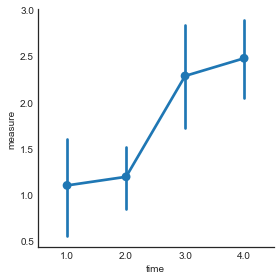

In [2]:
means = [1.1,1.5,2.1,2.9]
stds = [.8,.7,.9,.8]
n = 10
temp = [];condition = []; time = [];# phase in one condition
for ii,(m,s) in enumerate(zip(means,stds)):
    temp.append(np.random.normal(m,s,size=int(n)))
    condition.append([1]*n)
    time.append([ii+1]*n)
df1 = pd.DataFrame(np.vstack([np.concatenate(temp),
           np.concatenate(condition),
           np.concatenate(time)]).T,
                 columns = ['measure','condition','time'])
sns.factorplot(x='time',y='measure',data=df1,)

# condition 2

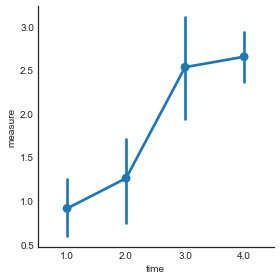

In [3]:
means = [1.2,1.4,2.4,3.1]
stds = [.8,.7,.9,.8]
n = 9
temp = [];condition = []; time = [];# phase in one condition
for ii,(m,s) in enumerate(zip(means,stds)):
    temp.append(np.random.normal(m,s,size=int(n)))
    condition.append([2]*n)
    time.append([ii+1]*n)
df2 = pd.DataFrame(np.vstack([np.concatenate(temp),
           np.concatenate(condition),
           np.concatenate(time)]).T,
                 columns = ['measure','condition','time'])
sns.factorplot(x='time',y='measure',data=df2,)

# condition 3

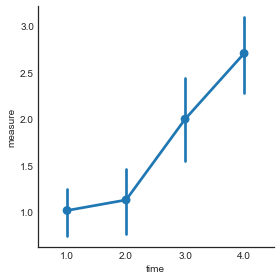

In [4]:
means = [1.0,1.2,2.1,2.8]
stds = [.8,.7,.9,.8]
n = 11
temp = [];condition = []; time = [];# phase in one condition
for ii,(m,s) in enumerate(zip(means,stds)):
    temp.append(np.random.normal(m,s,size=int(n)))
    condition.append([3]*n)
    time.append([ii+1]*n)
df3 = pd.DataFrame(np.vstack([np.concatenate(temp),
           np.concatenate(condition),
           np.concatenate(time)]).T,
                 columns = ['measure','condition','time'])
sns.factorplot(x='time',y='measure',data=df3,)

# condition 4

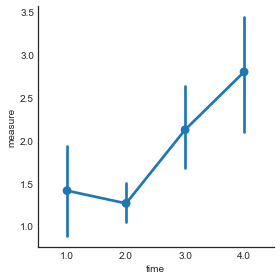

In [5]:
means = [1.1,1.2,2.3,2.8]
stds = [.8,.7,.9,.8]
n = 10
temp = [];condition = []; time = [];# phase in one condition
for ii,(m,s) in enumerate(zip(means,stds)):
    temp.append(np.random.normal(m,s,size=int(n)))
    condition.append([4]*n)
    time.append([ii+1]*n)
df4 = pd.DataFrame(np.vstack([np.concatenate(temp),
           np.concatenate(condition),
           np.concatenate(time)]).T,
                 columns = ['measure','condition','time'])
sns.factorplot(x='time',y='measure',data=df4,)

# Put the data into a data frame (excel format)

In [6]:
df = pd.concat([df1,df2,df3,df4])

# Superimpose the data together. X axis is the experiment time, y axis is the measures, and the experiment conditions are color coded

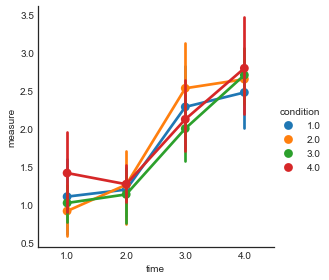

In [7]:
sns.factorplot(x='time',y='measure',hue='condition',data=df)

As the figure showed above, it is difficult to tell whether there is a significant difference among the means across measure conditions at a given time. However, we see a trend, a upward trend across time. 

The question is, what is a main effect of time? What does it mean? I interpret the main effect of time as the probability that there exist a difference among measures in different experiment time given that the same conditions = p($\Delta$ measure at times | condition) > chance level. But what would be the chance level? That should the classification/regression metrics for randomized data. 

# Before we do the machine learning, let's see what the results should be in a 2-way ANOVA

In [8]:
formula = 'measure ~ C(time) + C(condition) + C(time):C(condition)'
model = ols(formula,df).fit()
aov_table = anova_lm(model, typ=2)
aov_table = eta_squared(aov_table)
aov_table = omega_squared(aov_table)
print(aov_table)

                         sum_sq     df          F        PR(>F)    eta_sq  \
C(time)               69.400500    3.0  40.360536  5.438593e-19  0.446249   
C(condition)           0.822661    3.0   0.478427  6.977910e-01  0.005290   
C(time):C(condition)   2.759970    9.0   0.535029  8.471328e-01  0.017747   
Residual              82.536664  144.0        NaN           NaN       NaN   

                      omega_sq  
C(time)               0.433594  
C(condition)         -0.005746  
C(time):C(condition) -0.015366  
Residual                   NaN  


There is a main effect for the time but nothing else. 

# first, we apply the classification at each measure time, and see if there is a difference among conditions. Since it is a multiclassification problem, we shall have some strategies, but we shall see the results without any strategy.

In [10]:
scorer = metrics.make_scorer(metrics.accuracy_score,) # make a regression scorer, 0 is the worst, and 1 is the best.
for time in [1,2,3,4]:
    working_df = df[df['time'] == time]
    x = working_df['measure'].values.reshape(-1,1)
    y = working_df['condition'].values.reshape(-1,1).ravel()
    
    clf = RandomForestClassifier(random_state=12345) # a non liner classifier
    cv = ShuffleSplit(n_splits=3,random_state=12345,train_size=0.7,test_size=0.3)
    print('time at %d'%(time))
    score, permutation_scores, pvalue = permutation_test_score(clf,
                                                              x,y,
                                                              random_state=12345,n_permutations=int(1e3),
                                                              scoring=scorer)
    print("Regression score %s (pvalue : %s)" % (score, pvalue))

time at 1
Regression score 0.305982905983 (pvalue : 0.22977022977)
time at 2
Regression score 0.264957264957 (pvalue : 0.374625374625)
time at 3
Regression score 0.204700854701 (pvalue : 0.681318681319)
time at 4
Regression score 0.274786324786 (pvalue : 0.38961038961)


No significant differences among conditions at each measure time

In [16]:
# use some strategies
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier

# one vs one

This strategy will compare one condition to another condition, and hence we will have 10 binary comparisons

In [19]:
for time in [1,2,3,4]:
    working_df = df[df['time'] == time]
    x = working_df['measure'].values
    y = working_df['condition'].values
    x = x.reshape(x.shape[0],1)
    clf = RandomForestClassifier(random_state=12345)
    clf = OneVsOneClassifier(clf)
    cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=12345)
    print('time at %d'%(time))
    score, permutation_scores, pvalue = permutation_test_score(clf,
                                                              x,y,cv=cv,
                                                              random_state=12345,
                                                              scoring='accuracy')
    print("Classification score %s (pvalue : %s)" % (score, pvalue))

time at 1
Classification score 0.450427350427 (pvalue : 0.029702970297)
time at 2
Classification score 0.260256410256 (pvalue : 0.415841584158)
time at 3
Classification score 0.103418803419 (pvalue : 0.950495049505)
time at 4
Classification score 0.271367521368 (pvalue : 0.356435643564)


I think I will need to read more about the one vs one strategy to interpret the result. There is a marginal significant difference among conditions at measure time 1, which is surprise to me. Based on the figure above, it is hard to tell the difference. 

# one vs the rest

This strategy is to seperate out one condition and treat the others as one group to fit the classifier (estimator)

In [20]:
for time in [1,2,3,4]:
    working_df = df[df['time'] == time]
    x = working_df['measure'].values
    y = working_df['condition'].values
    x = x.reshape(x.shape[0],1)
    clf = RandomForestClassifier(random_state=12345)
    clf = OneVsRestClassifier(clf)
    cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=12345)
    print('time at %d'%(time))
    score, permutation_scores, pvalue = permutation_test_score(clf,
                                                              x,y,cv=cv,
                                                              random_state=12345,
                                                              scoring='accuracy')
    print("Classification score %s (pvalue : %s)" % (score, pvalue))

time at 1
Classification score 0.405982905983 (pvalue : 0.049504950495)
time at 2
Classification score 0.204700854701 (pvalue : 0.653465346535)
time at 3
Classification score 0.103418803419 (pvalue : 0.940594059406)
time at 4
Classification score 0.25811965812 (pvalue : 0.366336633663)


This confirms at least one of the conditions at time 1 is different from the others.

Based on the results using "one vs one" and "one vs rest", there exist a different among conditions at time 1. Using the "one vs one" comparison, there exist at least one pair (1 vs 2, 1 vs 3, ..., 3 vs 4) is different, and using the "one vs rest" comparison, there exist at leat one condition is different from the rest. 

In [12]:
from sklearn.model_selection import GroupKFold

In [13]:
Y = df['time'].values.reshape(-1, 1).ravel()
X = df['measure'].values.reshape(-1, 1)
group = df['condition'].values.astype(int)
clf = RandomForestClassifier(n_estimators=25,random_state=12345)
cv = GroupKFold(n_splits=3,)
score, permutation_scores, pvalue = permutation_test_score(clf,X,Y,groups=group,cv=cv,n_permutations=int(3e3),
                                                           random_state=12345,scoring=scorer)
print('classify time by measure (use measure to classify experiment time), grouped by conditions: %.3f, p val = %.4f'%(score,pvalue))

classify time by measure (use measure to classify experiment time), grouped by conditions: 0.341, p val = 0.0140


In [14]:
Y = df['condition'].values.reshape(-1, 1).ravel()
X = df['measure'].values.reshape(-1, 1)
group = df['time'].values.astype(int)
clf = RandomForestClassifier(n_estimators=25,random_state=12345)
cv = GroupKFold(n_splits=3,)
score, permutation_scores, pvalue = permutation_test_score(clf,X,Y,groups=group,cv=cv,random_state=12345,scoring=scorer)
print('classify condition by measure, grouped by experiment time: %.3f, p val = %.3f'%(score,pvalue))

classify condition by measure, grouped by experiment time: 0.292, p val = 0.178


# Let's review the anova table

In [15]:
aov_table

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(time),69.400500,3.0,40.360536,5.438593e-19,0.446249,0.433594
C(condition),0.822661,3.0,0.478427,6.977910e-01,0.005290,-0.005746
C(time):C(condition),2.759970,9.0,0.535029,8.471328e-01,0.017747,-0.015366
Residual,82.536664,144.0,NaN,NaN,NaN,NaN


The grouped multi-comparison confirms the main effect of time and indirectly shows that the main effect of conditions is not significant. 